# Homework 11: Regression Inference

**Reading**: 

* [Inference for Regression](https://www.inferentialthinking.com/chapters/16/Inference_for_Regression.html)

Please complete this notebook by filling in the cells provided. Before you begin, run the following cell. Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. 

For all problems that you must write our explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook! For example, if you use `max_temperature` in your answer to one question, do not reassign it later on.

In [4]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## An Introduction to Regression Inference

Previously in this class, we've used confidence intervals to quantify uncertainty about estimates. We can also run hypothesis tests using a confidence interval under the following procedure:

1. Define a null and alternative hypothesis (they must be of the form "The parameter is X" and "The parameter is not X").
2. Choose a p-value cutoff, and call it q.
3. Construct a $(100-q)\%$ interval using bootstrap sampling (for example, if your p-value cutoff q is 0.01, or 1%, then construct a 99% confidence interval).
4. Using the confidence interval, determine if your data are more consistent with your null or alternative hypothesis:
   * If the null hypothesis mean X is in your confidence interval, the data are more consistent with the null hypothesis.
   * If the null hypothesis mean X is *not* in your confidence interval, the data are more consistent with the alternative hypothesis.

More recently, we've discussed the use of linear regression to make predictions based on correlated variables. For example, we can predict the height of children based on the heights of their parents.

We can combine these two topics to make powerful statements about our population by using the following techniques:
- Bootstrapped interval for the true slope
- Bootstrapped prediction interval for y (given a particular value of x)

This homework explores these two methods.

## The Data
The [Snowy Plover](https://www.audubon.org/field-guide/bird/snowy-plover) is a tiny bird that lives on the coast in parts of California and elsewhere. It is so small that it is vulnerable to many predators, including people and dogs that don't look where they are stepping when they go to the beach. It is considered endangered in many parts of the U.S.

These data are about the eggs and newly-hatched chicks of the Snowy Plover. Here's a picture of [a parent bird incubating its eggs](http://cescos.fau.edu/jay/eps/articles/snowyplover.html).

<img src="plover_and_eggs.jpeg" alt="Plover and Eggs">

These data were collected at the Point Reyes National Seashore. The goal was to see how the size of an egg could be used to predict the weight of the resulting chick. The bigger the newly-hatched chick, the more likely it is to survive.

<img src="plover_and_chick.jpeg" alt="Plover and Chick">

Each row of the table below corresponds to one Snowy Plover egg and the resulting chick. Note how tiny the bird is:

- `Egg Length` and `Egg Breadth` (widest diameter) are measured in millimeters
- `Egg Weight` and `Bird Weight` are measured in grams; for comparison, a standard paper clip weighs about one gram

In [5]:
birds = Table.read_table('snowy_plover.csv')
birds

Egg Length,Egg Breadth,Egg Weight,Bird Weight
28.8,21.84,7.4,5.2
29.04,22.45,7.7,5.4
29.36,22.48,7.9,5.6
30.1,21.71,7.5,5.3
30.17,22.75,8.3,5.9
30.34,22.84,8.5,5.8
30.36,22.5,8.2,5.8
30.46,22.72,8.3,6
30.54,23.31,9,6.1
30.62,22.94,8.5,6.2


In this investigation, we will be using the egg weight to predict bird weight. Run the cell below to create a scatter plot of the egg weights and bird weights, along with their line of best fit.

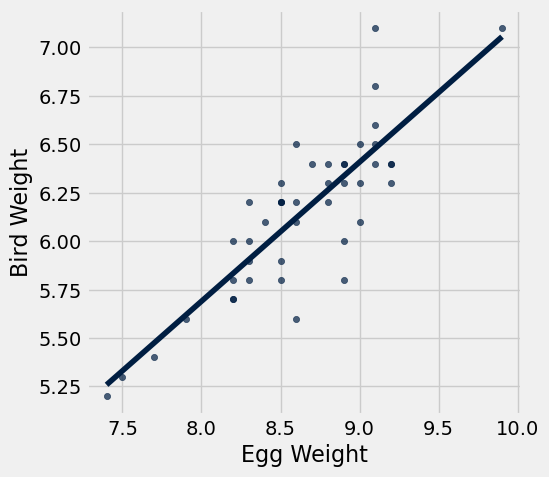

In [6]:
# Just run this cell and examine the scatter plot.
birds.scatter('Egg Weight', "Bird Weight", fit_line=True)

## 1. Finding the Bootstrap Confidence Interval for the True Slope

Looking at the scatter plot of our sample, we observe a linear relationship between egg weight and bird weight. However, relationships that appear in a sample might not exist in the population from which the sample was taken. 

We want to know if there truly exists a linear relationship between egg weight and bird weight for Snowy Plovers. If there is no linear relationship between the two variables, then we'd expect a correlation of 0. Consequently, the slope of the regression line would also be 0. 

**Question 1.1.** Let's run a hypothesis test using confidence intervals to see if there is a linear relationship between egg weight and bird weight. Define the null and alternative hypotheses that will allow you to conduct this test.

*Note:* Please write your answer **in the cell below** in the following format:
- **Null Hypothesis:**
- **Alternative Hypothesis:**

The null Hypothesis is that there is no correlation between egg weight and birth weight and that the slope of the regression line will be 0.
The alternative hypothesis is that there is a correlation between the two variables and that the slope of the regression line is not 0.

**Question 1.2.** Define the following two functions:

1. `standard_units`: This function takes in an array of numbers and returns an array containing those numbers converted to standard units.
2. `correlation`: This function takes in a table and two column names (one for *x* and one for *y*) and returns the correlation between these columns. 

In [7]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(tbl, x_col, y_col):
    x_standard = standard_units(tbl.column(x_col))
    y_standard = standard_units(tbl.column(y_col))
    return np.average(x_standard * y_standard)

**Question 1.3.** Using the functions you just implemented, create a function called `fit_line`.  It should take a table like `birds` and the column names associated to *x* and *y* as its arguments and return an array containing the slope and intercept of the regression line (in that order) that predicts the *y* column in the table using the *x* column.

In [8]:
def fit_line(tbl, x_col, y_col):
    r = correlation(tbl, x_col, y_col)
    y_sd = np.std(tbl.column(y_col))
    x_sd = np.std(tbl.column(x_col))
    slope = r * y_sd / x_sd

    x_mean = np.average(tbl.column(x_col))
    y_mean = np.average(tbl.column(y_col))
    intercept = y_mean - slope * x_mean

    return slope, intercept

fit_line(birds, "Egg Weight", "Bird Weight")

(0.7185153448936793, -0.058272261934288139)

Run this cell to plot the line produced by calling `fit_line` on the `birds` table.  

**Note:** You are not responsible for the code in the cell below, but make sure that your `fit_line` function generated a reasonable line for the data.

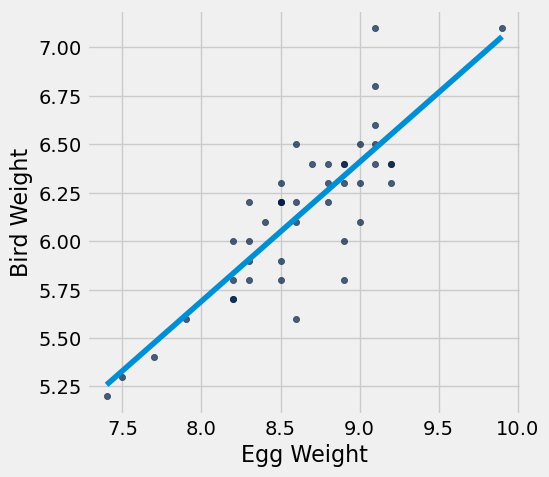

In [9]:
# Ensure your fit_line function fits a reasonable line 
# to the data in faithful, using the plot below.

slope, intercept = fit_line(birds, "Egg Weight", "Bird Weight")
birds.scatter("Egg Weight", "Bird Weight")
plt.plot([min(birds.column("Egg Weight")), max(birds.column("Egg Weight"))], 
         [slope*min(birds.column("Egg Weight"))+intercept, slope*max(birds.column("Egg Weight"))+intercept])
plt.show()

Now we have all the tools we need to create a confidence interval that quantifies our uncertainty about the true relationship between egg weight and bird weight.

**Question 1.4.** Create an array called `resampled_slopes` that contains the slope of the best fit line for 1000 bootstrap resamples of `birds`. Plot the distribution of these slopes.

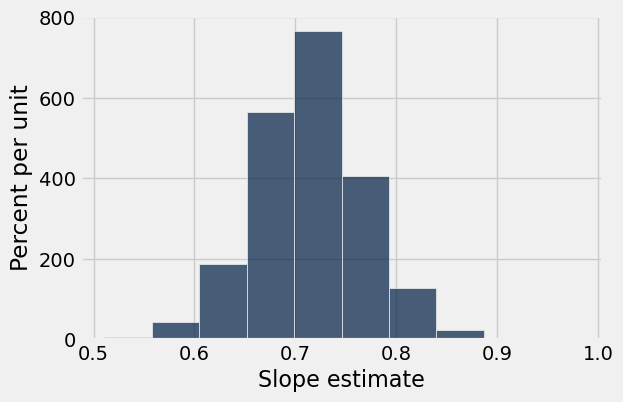

In [10]:
resample_slopes = make_array()

for i in np.arange(1000): 
    birds_resample = birds.sample()
    resample_line = correlation(birds_resample, "Egg Weight", "Bird Weight")
    resample_slope = resample_line * np.std(birds_resample.column("Bird Weight")) / np.std(birds_resample.column("Egg Weight"))
    resample_slopes = np.append(resample_slopes, resample_slope)
    
# DO NOT CHANGE THIS LINE
Table().with_column("Slope estimate", resample_slopes).hist()

**Question 1.5.** Use your resampled slopes to construct a 95% confidence interval for the true value of the slope.

In [11]:
lower_end = percentile(2.5, resample_slopes)
upper_end = percentile(97.5, resample_slopes)
print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for slope: [0.6095, 0.821349]


**Question 1.6.** Based on your confidence interval, would you reject or fail to reject the null hypothesis that the true slope is 0?  Why?  What p-value cutoff are you using?

We would reject the null hypothesis because the 95% confidence interval only contains values for slopes greater than 0. We are using a 5% cutt off or .05 p-value.

**Question 1.7.** What do you think the true slope is? You do not need an exact number.

*Hint:* Can you provide an interval that you think the true slope falls in?

The confidence interval provided a range of slope from .61 to .82 so the true slope should be about .7

<!-- END QUESTION -->



## 2. Finding the Bootstrap Prediction Interval

Suppose that we're visiting [Point Reyes](https://www.nps.gov/pore/index.htm) (which I highly recommend!) and stumble upon some Snowy Plover eggs; we'd like to know how heavy they'll be once they hatch. In other words, we want to use our regression line to make predictions about a bird's weight based on the weight of the corresponding egg.

However, just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions made based on the true regression line.

**Question 2.1.** Define the function `fitted_value`.  It should take in four arguments:

1. `table`: a table like `birds`.  We'll be predicting the values in the second column using the first.
2. `x_col`: the name of our x-column within the input `table`
3. `y_col`: the name of our y-column within the input `table`
2. `given_x`: a number, the value of the predictor variable for which we'd like to make a prediction.
  
The function should return the line’s prediction for the given x.

*Hint:* Make sure to use the `fit_line` function you defined in Question 1.3.

In [20]:
def fitted_value(table, x_col, y_col, given_x):
    line = fit_line(table, x_col, y_col)
    slope = line[0]
    intercept = line[1]

    return given_x * slope + intercept
# Here's an example of how fitted_value is used. The code below
# computes the prediction for the bird weight, in grams, based on
# an egg weight of 8 grams.
egg_weight_eight = fitted_value(birds, "Egg Weight", "Bird Weight", 8)
egg_weight_eight

5.6898504972151462

**Question 2.2.** Shayan, the resident Snowy Plover expert at Point Reyes, tells us that the egg he has been carefully observing has a weight of 9 grams. Using `fitted_value` above, assign the variable `experts_egg` to the predicted bird weight for Shayan's egg. 

In [25]:
experts_egg = fitted_value(birds, "Egg Weight", "Bird Weight", 9)
experts_egg

6.4083658421088252

A fellow parkgoer raises the following objection to your prediction:

> "Your prediction depends on your sample of 44 birds.  Wouldn't your prediction change if you had a different sample of birds?"

Having read section [16.3](https://inferentialthinking.com/chapters/16/3/Prediction_Intervals.html) of the textbook, you know just the response! Had the sample been different, the regression line would have been different too. This would ultimately result in a different prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

**Question 2.3.** Define a function `compute_resampled_line` that takes in a table `tbl`and two column names, `x_col` and `y_col`, and returns an array containing the parameters of the best fit line (slope and intercept) for one bootstrapped resample of the table.

In [24]:
def compute_resampled_line(tbl, x_col, y_col):
    resample = tbl.sample()
    resampled_line = fit_line(resample, x_col, y_col)
    return resampled_line

**Run** the following cell below in order to define the function `bootstrap_lines`.  It takes in four arguments:
1. `tbl`: a table like `birds`
2. `x_col`: the name of our x-column within the input `tbl`
3. `y_col`: the name of our y-column within the input `tbl`
4. `num_bootstraps`: an integer, a number of bootstraps to run.

It returns a *table* with one row for each bootstrap resample and the following two columns:
1. `Slope`: the bootstrapped slopes 
2. `Intercept`: the corresponding bootstrapped intercepts 

In [26]:
def bootstrap_lines(tbl, x_col, y_col, num_bootstraps):
    resampled_slopes = make_array()
    resampled_intercepts = make_array() 
    for i in np.arange(num_bootstraps): 
        resampled_line = compute_resampled_line(tbl, x_col, y_col) 
        resampled_slope = resampled_line[0] 
        resampled_intercept = resampled_line[1]
        resampled_slopes = np.append(resampled_slopes,resampled_slope)
        resampled_intercepts = np.append(resampled_intercepts,resampled_intercept)
    tbl_lines = Table().with_columns('Slope', resampled_slopes, 'Intercept', resampled_intercepts)
    return tbl_lines

regression_lines = bootstrap_lines(birds, "Egg Weight", "Bird Weight", 1000)
regression_lines

Slope,Intercept
0.726691,-0.145352
0.673752,0.335311
0.803994,-0.76252
0.675802,0.255665
0.700316,0.0661609
0.753668,-0.320872
0.718414,-0.0889933
0.738157,-0.207728
0.681841,0.216019
0.729733,-0.196587


**Question 2.4.** Create an array called `predictions_for_nine` that contains the predicted bird weights based on an egg of weight 9 grams for each regression line in `regression_lines`.

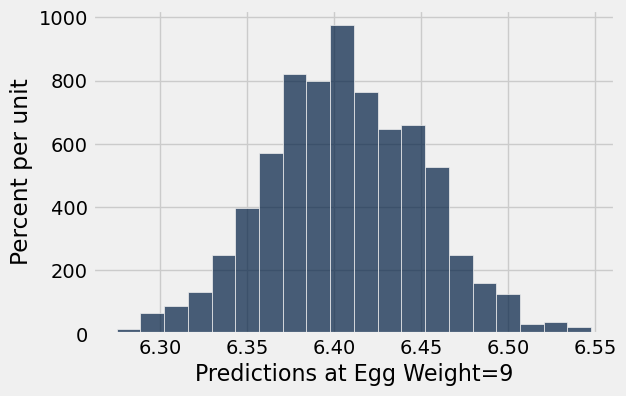

In [28]:
predictions_for_nine = regression_lines.column("Slope") * 9 + regression_lines.column("Intercept")

# This will make a histogram of your predictions:
table_of_predictions = Table().with_column('Predictions at Egg Weight=9', predictions_for_nine)
table_of_predictions.hist('Predictions at Egg Weight=9', bins=20)

**Question 2.6.** Use your resampled predictions to construct a 95% confidence interval for the true value of the mean birds' weight for 9 gram eggs.

In [29]:
lower_end_pred = percentile(2.5, predictions_for_nine)
upper_end_pred = percentile(97.5, predictions_for_nine)
print("95% confidence interval for mean bird weight for a 9 gram egg:")
print("[{:g}, {:g}]".format(lower_end_pred, upper_end_pred))

95% confidence interval for mean bird weight for a 9 gram egg:
[6.31888, 6.4951]


**Question 2.7.** Set `plover_statements` to an array of integer(s) that correspond to statement(s) that are true.

1. The 95% confidence interval covers 95% of the bird weights for eggs that had a weight of nine grams in `birds`.

2. The 95% confidence interval gives a sense of how much actual bird weights differ from your prediction.

3. The 95% confidence interval quantifies the uncertainty in our estimate of what the true line would predict.

In [30]:
plover_statements = make_array(3)

You're done with Homework 11!  